In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def random_orthogonal_basis(k, attack=False):
    """
    Generates a random orthogonal basis for R^k.

    Parameters:
    k (int): Dimension of the space.

    Returns:
    np.ndarray: A k x k orthogonal matrix whose columns form an orthogonal basis.
    """
    # Generate a random k x k matrix with entries from a standard normal distribution
    A = np.random.randn(k, k)
    if attack:
        # correct A to start with the cursed vector
        A[:,0] = -np.ones(k)
        A[0,0] = k**(1/2)
        A = A.T
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

def gram_schmidt(A):
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

# Example usage:
k = 100  # Dimension of the space
basis = random_orthogonal_basis(k)
print(f"Random orthogonal basis for R^{k}:")

Random orthogonal basis for R^100:


In [4]:
def inf(matrix):
    """
    Computes the infinity norm of a matrix.

    Parameters:
    matrix (array-like): A 2D list or NumPy array representing the matrix.

    Returns:
    float: The infinity norm of the matrix.
    """
    # Ensure the input is a NumPy array
    matrix = np.array(matrix)
    
    # Compute the infinity norm
    
    infinity_norm = np.sort(np.sum(np.abs(matrix), axis=1))[int(k-1)] #np.max(np.sum(np.abs(matrix), axis=1))
    return infinity_norm

In [5]:
def get_fourier(k):
    mat = np.zeros((k,k))
    x = np.pi*np.arange(k)/k
    for i in range(k):
        mat[:,i] = np.cos(i*x)/(k**0.5)
    return mat

def get_poly(k):
    mat = np.zeros((k,k))
    x = np.pi*np.arange(k)/k
    for i in range(k):
        mat[:,i] = x**i/(k**0.5)
    return mat


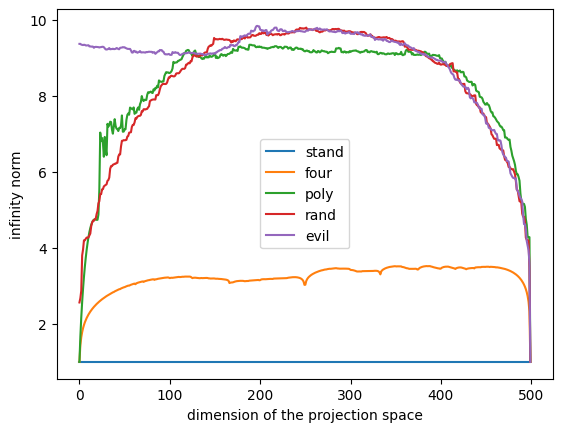

In [9]:
k = 500
x = np.arange(k)
basis_stand = np.identity(k)
basis_four = gram_schmidt(get_fourier(k))
basis_poly = gram_schmidt(get_poly(k))
basis_rand = random_orthogonal_basis(k)
basis_evil = random_orthogonal_basis(k, attack=True)

basis_list = [basis_stand, basis_four, basis_poly, basis_rand, basis_evil]
labels = ['stand', 'four', 'poly', 'rand', 'evil']

for i in range(len(basis_list)):   

    # choose the basis
    basis = basis_list[i] 
    mat = np.zeros((k,k))

    # infnorms collects the infinity norm of the matrices
    infnorms = np.zeros(k)

    for d in range(k):

        # we incrementally update the matrix adding more and more basis functions
        mat += np.dot(basis[:,d:d+1], basis[:,d:d+1].T)
        infnorms[d] = inf(mat)

    plt.plot(x, infnorms, label = labels[i])


plt.legend()
plt.xlabel('dimension of the projection space')
plt.ylabel('infinity norm')
plt.show()